In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wandb
import sys
# append .. in folder connected
sys.path.append("..")

from WewerForecast.utils import fix_index_to_1h
from WewerForecast import TimeSeriesDebugLinearLayer

In [2]:
#  confoguration for wandb
run = wandb.init(
    project='Water-Demand-Forecasting',
    notes='Testing out wandb',
)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: christiaanwewer. Use `wandb login --relogin` to force relogin


In [3]:

wandb.config = {
    'model_name':'LSTM_tests_109',
    'log_loss_interval':0,
    'save_path':r'model_saves',
    'save_model_interval':10,       
    'target_feature':'DMA A (L/s)',
    'include_historic_target':True,
    'historic_features':None,
    'future_features': 'DMA A (L/s)',
    'scaler_dict' : {'DMA A (L/s)': 'normalization'},
    'historic_sequence_length':24,
    'prediction_horizon_length':24*7,
    'batch_size':32,
    'epochs':100,
    'learning_rate':0.001,
    'loss_function':'MultiQuantileLoss',
    'quantiles': [0.1, 0.5, 0.9],
    'masked_loss': False
}

In [36]:
# load excel files from ../data/raw/WDSA into a pandas dataframe, col 0 Date-time CET-CEST (DD/MM/YYYY HH:mm)
df_inflow = pd.read_excel(r'../data/raw/WDSA/InflowData_1.xlsx', index_col=0, parse_dates=True, date_format='%d/%m/%Y %H:%M')
df_weather = pd.read_excel(r'../data/raw/WDSA/WeatherData_1.xlsx', index_col=0, parse_dates=True, date_format='%d/%m/%Y %H:%M')

# get latest start date of both datasets
start_date = max(df_inflow.dropna().index.min(), df_weather.dropna().index.min())

# get earliest end date of both datasets
end_date = min(df_inflow.dropna().index.max(), df_weather.dropna().index.max())

# get the intersection of both datasets
df_inflow = df_inflow.loc[start_date:end_date]
df_weather = df_weather.loc[start_date:end_date]

df_inflow = fix_index_to_1h(df_inflow)
df_weather = fix_index_to_1h(df_weather)

# add binary column to df_weather that indicates if it is weekend or midweek, make sure it is an integer
df_weather['IsWeekend'] = (df_weather.index.dayofweek > 4).astype(float)

# add hour of the day as a column to both dataframes
df_weather['Hour'] = df_weather.index.hour.astype(float)

# divide into first 75% training and 25% validation
divider = int(len(df_inflow) * 0.75)
df_inflow_train = df_inflow.iloc[:divider]
df_inflow_val = df_inflow.iloc[divider:]
df_weather_train = df_weather.iloc[:divider]
df_weather_val = df_weather.iloc[divider:]

# merge datasets
df_train = pd.merge(df_inflow_train, df_weather_train, left_index=True, right_index=True)
df_train = df_train.interpolate(method='linear')

df_val = pd.merge(df_inflow_val, df_weather_val, left_index=True, right_index=True)
df_val_interpolated = df_val.interpolate(method='linear')

In [5]:
# make TimeSeriesLSTM object with the configuration from wandb in one line
model = TimeSeriesDebugLinearLayer(
    df_train,
    df_val_interpolated,
    *list(wandb.config.values())
)



In [6]:
model.train()

Val loss: 0.48482508332498614
Epoch 1
-----
Train loss: 0.1717388738075207
Val loss: 0.13329075196737883

Epoch 2
-----
Train loss: 0.09116681490478845
Val loss: 0.08947664371100805

Epoch 3
-----
Train loss: 0.05931405085941841
Val loss: 0.06238631167078531

Epoch 4
-----
Train loss: 0.040336423534257655
Val loss: 0.04246235266327858

Epoch 5
-----
Train loss: 0.02680013351913156
Val loss: 0.025635224917242603

Epoch 6
-----
Train loss: 0.015299070600805612
Val loss: 0.012464207206522264

Epoch 7
-----
Train loss: 0.007506359296304913
Val loss: 0.0062177824557468455

Epoch 8
-----
Train loss: 0.005263870283319005
Val loss: 0.005774529670835823

Epoch 9
-----
Train loss: 0.004879797710876527
Val loss: 0.005308254972420713

Epoch 10
-----
Train loss: 0.004559575308692353
Val loss: 0.00469504742662833

Epoch 11
-----
Train loss: 0.004467813028343793
Val loss: 0.004968021085025162

Epoch 12
-----
Train loss: 0.004292759158777009
Val loss: 0.004773238062938695

Epoch 13
-----
Train loss: 0

In [ ]:
# model.load_model('model_saves/LSTM_tests_105/LSTM_tests_105_30_epochs.pt')

Loading model...
Model loaded


In [10]:
# predict 24*7 hours into the future
df_prediction_data = df_train.iloc[1300:2800]
model.set_prediction_data(df_prediction_data)
df_prediction = model.predict(1) # just mse shape: [1,24,1]
# transform df_prediction back to original scale
df_truth = df_prediction_data.iloc[:2*24*7]

In [11]:
df_prediction

,Prediction 0.1th quantile DMA A (L/s),Prediction 0.5th quantile DMA A (L/s),Prediction 0.9th quantile DMA A (L/s)
Date-time CET-CEST (DD/MM/YYYY HH:mm),,,
2021-04-11 01:00:00,35.977222,35.977222,35.977222
2021-04-11 02:00:00,35.616272,35.616272,35.616272
2021-04-11 03:00:00,35.447903,35.447903,35.447903
2021-04-11 04:00:00,35.230076,35.230076,35.230076
2021-04-11 05:00:00,35.189938,35.189938,35.189938
...,...,...,...
2021-04-17 20:00:00,29.531713,29.531713,29.531713
2021-04-17 21:00:00,27.533108,27.533108,27.533108
2021-04-17 22:00:00,24.589790,24.589790,24.589790


In [26]:
s1, s2 = model.scaling_coefficients['DMA A (L/s)']

In [20]:
mean = df_train['DMA A (L/s)'].mean()
std = df_train['DMA A (L/s)'].std()
df_train_normed = (df_train - mean) / std

In [27]:
df_prediction_normed = df_prediction * s1 + s2

In [28]:
df_prediction_normed

,Prediction 0.1th quantile DMA A (L/s),Prediction 0.5th quantile DMA A (L/s),Prediction 0.9th quantile DMA A (L/s)
Date-time CET-CEST (DD/MM/YYYY HH:mm),,,
2021-04-11 01:00:00,9.801622,9.801622,9.801622
2021-04-11 02:00:00,9.672672,9.672672,9.672672
2021-04-11 03:00:00,9.612522,9.612522,9.612522
2021-04-11 04:00:00,9.534702,9.534702,9.534702
2021-04-11 05:00:00,9.520363,9.520363,9.520363
...,...,...,...
2021-04-17 20:00:00,7.498954,7.498954,7.498954
2021-04-17 21:00:00,6.784949,6.784949,6.784949
2021-04-17 22:00:00,5.733445,5.733445,5.733445


In [30]:
from WewerForecast.utils import Scaler

In [43]:
scaler = Scaler(
    df=df_train,
    columns_to_scale=['DMA A (L/s)'],
    scaling_methods=['normalization']
)

# scale training data
df_train_1, scaling_coefficients = scaler.transform_df(df_train)
df_val_1, _ = scaler.transform_df(df_val)

In [40]:
df_train['DMA A (L/s)'].mean(), df_train['DMA A (L/s)'].std()

(8.541026969857219, 2.7991484771440454)

In [41]:
df_train_1['DMA A (L/s)'].mean(), df_train_1['DMA A (L/s)'].std()

(-4.208396954263946e-16, 0.9999999999999999)

In [44]:
df_val_1['DMA A (L/s)'].mean(), df_val_1['DMA A (L/s)'].std()

(0.05229903689985804, 1.042453419701884)

In [31]:
Scaler.compute_scaling_coefficients(

TypeError: compute_scaling_coefficients() takes 2 positional arguments but 3 were given

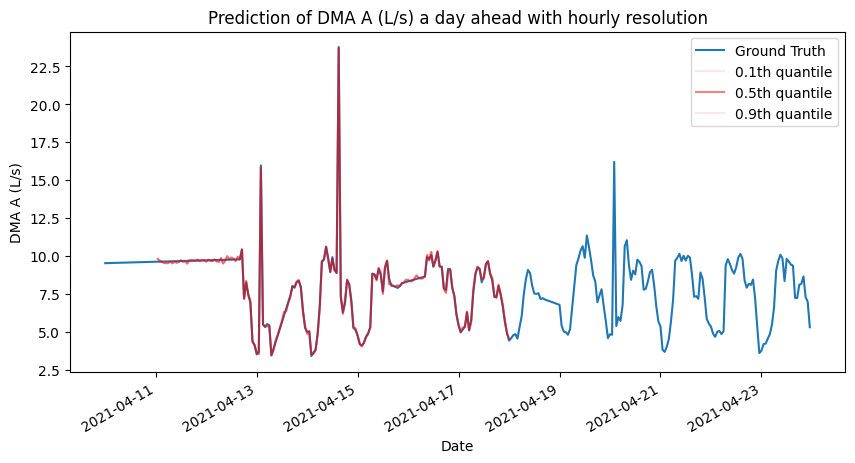

In [29]:
# plot prediction along with prediction data
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_truth.index, df_truth['DMA A (L/s)'], label='Ground Truth')
alpha = [quantile if quantile < 0.5 else 1-quantile for quantile in wandb.config['quantiles']]
for i, quantile in enumerate(wandb.config['quantiles']):
    df_prediction_normed[f'Prediction {quantile}th quantile DMA A (L/s)'].plot(
        ax=ax, 
        color= 'red',
        alpha=alpha[i],
        label=f'{quantile}th quantile'
    )
ax.set_xlabel('Date')
ax.set_ylabel('DMA A (L/s)')
ax.legend()
ax.set_title('Prediction of DMA A (L/s) a day ahead with hourly resolution')
plt.show()

# # resample above data to 6h resolution and plot again
# df_truth_6h = df_truth.resample('6h').mean()
# df_prediction_6h = df_prediction.resample('6h').mean()
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot(df_truth_6h.index, df_truth_6h['DMA A (L/s)'], label='Ground Truth')
# alpha = [quantile if quantile < 0.5 else 1-quantile for quantile in wandb.config['quantiles']]
# for i, quantile in enumerate(wandb.config['quantiles']):
#     df_prediction_6h[f'Prediction {quantile}th quantile DMA A (L/s)'].plot(
#         ax=ax, 
#         color= 'red',
#         alpha=alpha[i],
#         label=f'{quantile}th quantile'
#     )
# ax.set_xlabel('Date')
# ax.set_ylabel('DMA A (L/s)')
# ax.legend()
# ax.set_title('Prediction of DMA A (L/s) a day ahead with 6h resolution')
# plt.show()


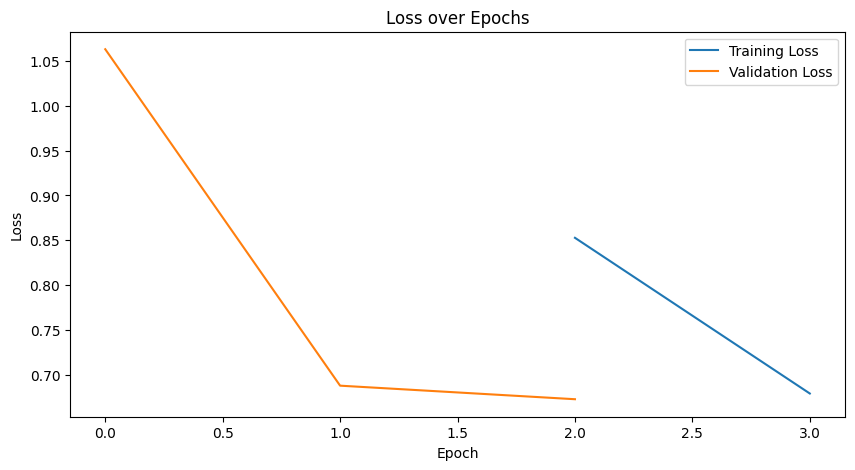

In [ ]:
# plot loss over epochs
# note that the first validation loss is an untrained loss and thus trained before the first epoch
# the first training loss is the loss after the first epoch
# model.train_losses
# model.val_losses

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.arange(1, len(model.train_losses)+1), model.train_losses, label='Training Loss')
ax.plot(np.arange(0, len(model.val_losses)),model.val_losses, label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.set_title('Loss over Epochs')
plt.show()

